# Application: Longitudinal Vehicle Model

#### References

---

**Remark**

This notebook has been inspired from Coursera's course Introduction to Self-Driving Cars 

---

In this notebook, we will implement the forward longitudinal vehicle model. The model accepts throttle inputs and steps through the longitudinal dynamic equations. Once implemented, you will be given a set of inputs that drives over a small road slope to test your model.

The input to the model is a throttle percentage $x_\theta \in [0,1]$ which provides torque to the engine and subsequently accelerates the vehicle for forward motion. 

The dynamic equations consist of many stages to convert throttle inputs to wheel speed (engine -> torque converter -> transmission -> wheel). These stages are bundled together in a single inertia term $J_e$ which is used in the following combined engine dynamic equations.


\begin{align}
    J_e \dot{\omega}_e &= T_e - (GR)(r_{eff} F_{load}) \\ m\ddot{x} &= F_x - F_{load}
\end{align}

Where $T_e$ is the engine torque, $GR$ is the gear ratio, $r_{eff}$ is the effective radius, $m$ is the vehicle mass, $x$ is the vehicle position, $F_x$ is the tire force, and $F_{load}$ is the total load force. 

The engine torque is computed from the throttle input and the engine angular velocity $\omega_e$ using a simplified quadratic model. 

\begin{align}
    T_e = x_{\theta}(a_0 + a_1 \omega_e + a_2 \omega_e^2)
\end{align}

The load forces consist of aerodynamic drag $F_{aero}$, rolling friction $R_x$, and gravitational force $F_g$ from an incline at angle $\alpha$. The aerodynamic drag is a quadratic model and the friction is a linear model.


\begin{align}
    F_{load} &= F_{aero} + R_x + F_g \\
    F_{aero} &= \frac{1}{2} C_a \rho A \dot{x}^2 = c_a \dot{x}^2\\
    R_x &= N(\hat{c}_{r,0} + \hat{c}_{r,1}|\dot{x}| + \hat{c}_{r,2}\dot{x}^2) \approx c_{r,1} \dot{x}\\
    F_g &= mg\sin{\alpha}
\end{align}


Note that the absolute value is ignored for friction since the model is used for only forward motion ($\dot{x} \ge 0$).  The tire force is computed using the engine speed and wheel slip equations.

\begin{align}
    \omega_w &= (GR)\omega_e \\
    s &= \frac{\omega_w r_e - \dot{x}}{\dot{x}}\\
    F_x &= \left\{\begin{array}{lr}
        cs, &  |s| < 1\\
        F_{max}, & \text{otherwise}
        \end{array}\right\} 
\end{align}

Where $\omega_w$ is the wheel angular velocity and $s$ is the slip ratio. 

We setup the longitudinal model inside a Python class below. The vehicle begins with an initial velocity of 5 m/s and engine speed of 100 rad/s. All the relevant parameters are defined and like the bicycle model, a sampling time of 10ms is used for numerical integration.

Using the model, you can send constant throttle inputs to the vehicle in the cell below. You will observe that the velocity converges to a fixed value based on the throttle input due to the aerodynamic drag and tire force limit. A similar velocity profile can be seen by setting a negative incline angle αα. In this case, gravity accelerates the vehicle to a terminal velocity where it is balanced by the drag force.


We will now drive the vehicle over a slope as shown in the diagram below.

![ramp](ramp.png)

To climb the slope, a trapezoidal throttle input is provided for the next 20 seconds as shown in the figure below. 

![throttle](throttle.png)

The vehicle begins at 20% throttle and gradually increases to 50% throttle. This is maintained for 10 seconds as the vehicle climbs the steeper slope. Afterwards, the vehicle reduces the throttle to 0.

In the cell below, implement the ramp angle profile $\alpha (x)$ and throttle profile $x_\theta (t)$ and step them through the vehicle dynamics. The vehicle position $x(t)$ is saved in the array $\textit{x_data}$. This will be used to grade your solution.

In [54]:
# Need these so that Jupyter can find the simulator types
import os
import sys
nb_dir = os.path.split(os.getcwd())[0]
if nb_dir not in sys.path:
    sys.path.append(nb_dir)

In [55]:
import math
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

from vehicle.vehicle_base import VehicleBase
from dynamics.dynamics_base import DynamicsBase
from systems.system_state import SysState
from ode_integrators.forward_euler import ODEScalarFWDEuler
from physics.physics import Physics
from plot.two_d_plotter import TwoDPlotter

In [56]:
class EngineDynamics(DynamicsBase):

    def __init__(self, properties, sample_time, init_condition):
        DynamicsBase.__init__(self)
        self.__properties = properties
        self.set_integrator("w_e", integrator=ODEScalarFWDEuler(step_size=sample_time, init_condition=init_condition))
        self.__state = 0.0

    def __compute_t_e(self, **kwargs):
        # get the previous velocity
        w_e_old = self.get_old_state("w_e", 0)
        throttle = kwargs['throttle']
        return throttle * (self.__properties['a_0'] + self.__properties['a_1'] * w_e_old + self.__properties['a_2'] * w_e_old ** 2)

    def __compute_rhs(self, **kwargs):
        T_e = self.__compute_t_e(**kwargs)
        GR = kwargs['GR']
        r_eff = kwargs['r_e']
        F_load = kwargs['F_load']
        return (T_e - GR * r_eff * F_load) / self.__properties['J_e']

    @property
    def state(self):
        return self.__state

    @state.setter
    def state(self, value):
        self.__state = value

    def execute(self, **kwargs):
        """
        performs one time-step of the enigne dynamics equation
        """
        kwargs['f'] = self.__compute_rhs
        self.__state = self.get_integrator("w_e").execute(**kwargs)

        

In [57]:
class VehicleDynamics(DynamicsBase):

    def __init__(self, sample_time, init_condition):
        DynamicsBase.__init__(self)
        self.__state = SysState(n_entries=3)
        self.__state.add_state("x", 0)
        self.__state.add_state("v", 1)
        self.__state.add_state("w_e", 2)

        # integrator for the velocity
        self.set_integrator("velocity",
                            integrator=ODEScalarFWDEuler(init_condition=init_condition, step_size=sample_time))

    @property
    def state(self):
        return self.__state

    @state.setter
    def state(self, value):
        self.__state = value

    def execute(self, **kwargs):
        """
        performs one time-step of the velocity dynamics equation
        """
        v_new = self.get_integrator("velocity").execute(**kwargs)
        self.__state.set_state_value_by_name(name="v", value=v_new)

        x = self.__state.get_state_value_by_name('x')
        x += v_new*self.get_integrator("velocity").step_size
        self.__state.set_state_value_by_name(name='x', value=x)
        
        

In [58]:
class Vehicle(VehicleBase):

    def __init__(self, properties, sample_time, init_condition):
        VehicleBase.__init__(self, properties)
        self.__dynamics = VehicleDynamics(sample_time=sample_time, init_condition=init_condition)

    @property
    def state(self):
        return self.__dynamics.state

    @state.setter
    def state(self, value):
        self.__dynamics.state = value

    def get_old_state(self, name, idx):
        return self.__dynamics.get_old_state(name=name, idx=idx)

    def set_old_state(self, name, idx, value):
        self.__dynamics.set_old_state(name=name, idx=idx, value=value)

    def __get_f_load(self, **kwargs):

        v = self.get_old_state(name="velocity", idx=0)
        F_aero = self.get_property("c_a") * v ** 2
        R_x = self.get_property("c_r1") * v
        F_g = self.get_property("m") * Physics.gravity_constant() * math.sin(kwargs['alpha'])
        return F_aero + R_x + F_g

    def __get_f_x(self, **kwargs):
        w_e = self.get_property("propulsion").get_old_state(name='w_e', idx=0)
        w_w = self.get_property("GR") * w_e
        v = self.get_old_state(name="velocity", idx=0)
        s = (w_w * self.get_property("r_e") - v) / v

        if math.fabs(s) < 1:
            return self.get_property("c") * s

        return self.get_property("F_max")

    def __compute_rhs(self, **kwargs):
        return (self.__get_f_x(**kwargs) - self.__get_f_load(**kwargs))/self.get_property('m')

    def execute(self, **kwargs):
        F_load = self.__get_f_load(**kwargs)
        kwargs['F_load'] = F_load
        kwargs['GR'] = self.get_property("GR")
        kwargs['r_e'] = self.get_property("r_e")
        self.get_property("propulsion").execute(**kwargs)
        kwargs['f'] = self.__compute_rhs
        self.__dynamics.execute(**kwargs)
    

In [59]:
def constant_throttle():

    ### SIMULATION DRIVER

    sample_time = 0.01
    time_end = 100

    t_data = np.arange(0, time_end, sample_time)
    v_data = np.zeros_like(t_data)

    engine_properties = {"a_0": 400,
                         "a_1": 0.1,
                         "a_2": -0.0002,
                         "J_e": 10}

    init_engine_speed = 100.0  # rad/s
    propulsion = EngineDynamics(properties=engine_properties,
                                sample_time=sample_time,
                                init_condition=init_engine_speed)

    # Gear ratio, effective radius, mass + inertia
    vehicle_properties = {"GR": 0.35,
                          "r_e": 0.3,
                          "J_e": 10,
                          "m": 2000,
                          "c_a": 1.36,
                          "c_r1": 0.01,
                          "c": 10000,
                          "F_max": 10000,
                          "propulsion": propulsion}

    init_velocity = 5.0  # m/s
    model = Vehicle(properties=vehicle_properties,
                    sample_time=sample_time,
                    init_condition=init_velocity)

    # throttle percentage between 0 and 1
    throttle = 0.2

    # incline angle (in radians)
    alpha = 0

    kwargs = {"throttle": throttle, "alpha": alpha}

    # the simulation time
    time = 0.0
    for i in range(t_data.shape[0]):
        print("At time: %f" % time)

        model.execute(**kwargs)
        v_data[i] = model.state.get_state_value_by_name("v")
        print("Vehicle velcoity %f" % model.state.get_state_value_by_name("v"))

        time += sample_time

    plotter = TwoDPlotter(xlabel="Time in secs", ylabel="Velocity")
    plotter.plot(x=t_data, y=v_data)
    plotter.show_plots(show_grid=True)


In [60]:
def calculate_alpha(x):

    if x < 60.0:
        return math.atan(3.0/60.0)

    if x >= 60.0 and x <= 150.0:
        return math.atan(12.0/90.0)

    return 0.0


def calculate_throttle(time):

    if time <= 5.0:

        beta = 0.2
        alpha = 0.3/5.0
        return alpha*time + beta

    if time <= 15.0:
        return 0.5

    return 0.0

def variable_throttle():

        ### SIMULATION DRIVER

        sample_time = 0.01
        time_end = 100

        t_data = np.arange(0, time_end, sample_time)
        v_data = np.zeros_like(t_data)
        throttle_data = np.zeros_like(t_data)
        alpha_data = np.zeros_like(t_data)

        engine_properties = {"a_0": 400,
                             "a_1": 0.1,
                             "a_2": -0.0002,
                             "J_e": 10}

        init_engine_speed = 100.0  # rad/s
        propulsion = EngineDynamics(properties=engine_properties,
                                    sample_time=sample_time,
                                    init_condition=init_engine_speed)

        # Gear ratio, effective radius, mass + inertia
        vehicle_properties = {"GR": 0.35,
                              "r_e": 0.3,
                              "J_e": 10,
                              "m": 2000,
                              "c_a": 1.36,
                              "c_r1": 0.01,
                              "c": 10000,
                              "F_max": 10000,
                              "propulsion": propulsion}

        init_velocity = 5.0  # m/s
        model = Vehicle(properties=vehicle_properties,
                        sample_time=sample_time,
                        init_condition=init_velocity)

        kwargs = dict()

        # the simulation time
        time = 0.0
        for i in range(t_data.shape[0]):
            print("At time: %f" % time)

            pos = model.state.get_state_value_by_name("x")

            # incline angle (in radians)
            alpha = calculate_alpha(pos)
            alpha_data[i] = alpha

            # throttle percentage between 0 and 1
            throttle = calculate_throttle(time)
            throttle_data[i] = throttle

            print("\talpha %f throttle %f"%(alpha, throttle))

            kwargs['alpha'] = alpha
            kwargs["throttle"] = throttle

            model.execute(**kwargs)
            v_data[i] = model.state.get_state_value_by_name("v")
            print("Vehicle velcoity %f" % model.state.get_state_value_by_name("v"))

            time += sample_time


        plotter = TwoDPlotter(xlabel="Time in secs", ylabel="Throttle/alpha")
        plotter.plot(x=t_data, y=throttle_data, label="Throttle")
        plotter.plot(x=t_data, y=alpha_data, label="alpha")
        #plotter.plot(x=t_data, y=v_data)
        plotter.show_plots(show_legend=True, show_grid=True)

At time: 0.000000
Vehicle velcoity 5.049830
At time: 0.010000
Vehicle velcoity 5.099656
At time: 0.020000
Vehicle velcoity 5.149479
At time: 0.030000
Vehicle velcoity 5.199298
At time: 0.040000
Vehicle velcoity 5.249114
At time: 0.050000
Vehicle velcoity 5.298927
At time: 0.060000
Vehicle velcoity 5.348352
At time: 0.070000
Vehicle velcoity 5.396929
At time: 0.080000
Vehicle velcoity 5.444689
At time: 0.090000
Vehicle velcoity 5.491660
At time: 0.100000
Vehicle velcoity 5.537871
At time: 0.110000
Vehicle velcoity 5.583347
At time: 0.120000
Vehicle velcoity 5.628113
At time: 0.130000
Vehicle velcoity 5.672192
At time: 0.140000
Vehicle velcoity 5.715606
At time: 0.150000
Vehicle velcoity 5.758376
At time: 0.160000
Vehicle velcoity 5.800522
At time: 0.170000
Vehicle velcoity 5.842063
At time: 0.180000
Vehicle velcoity 5.883017
At time: 0.190000
Vehicle velcoity 5.923402
At time: 0.200000
Vehicle velcoity 5.963233
At time: 0.210000
Vehicle velcoity 6.002527
At time: 0.220000
Vehicle velcoi

Vehicle velcoity 13.290040
At time: 6.780000
Vehicle velcoity 13.295877
At time: 6.790000
Vehicle velcoity 13.301711
At time: 6.800000
Vehicle velcoity 13.307541
At time: 6.810000
Vehicle velcoity 13.313368
At time: 6.820000
Vehicle velcoity 13.319191
At time: 6.830000
Vehicle velcoity 13.325010
At time: 6.840000
Vehicle velcoity 13.330826
At time: 6.850000
Vehicle velcoity 13.336638
At time: 6.860000
Vehicle velcoity 13.342446
At time: 6.870000
Vehicle velcoity 13.348251
At time: 6.880000
Vehicle velcoity 13.354052
At time: 6.890000
Vehicle velcoity 13.359850
At time: 6.900000
Vehicle velcoity 13.365644
At time: 6.910000
Vehicle velcoity 13.371434
At time: 6.920000
Vehicle velcoity 13.377221
At time: 6.930000
Vehicle velcoity 13.383005
At time: 6.940000
Vehicle velcoity 13.388785
At time: 6.950000
Vehicle velcoity 13.394561
At time: 6.960000
Vehicle velcoity 13.400334
At time: 6.970000
Vehicle velcoity 13.406103
At time: 6.980000
Vehicle velcoity 13.411869
At time: 6.990000
Vehicle ve

At time: 11.980000
Vehicle velcoity 15.961149
At time: 11.990000
Vehicle velcoity 15.965696
At time: 12.000000
Vehicle velcoity 15.970242
At time: 12.010000
Vehicle velcoity 15.974786
At time: 12.020000
Vehicle velcoity 15.979327
At time: 12.030000
Vehicle velcoity 15.983867
At time: 12.040000
Vehicle velcoity 15.988405
At time: 12.050000
Vehicle velcoity 15.992941
At time: 12.060000
Vehicle velcoity 15.997475
At time: 12.070000
Vehicle velcoity 16.002007
At time: 12.080000
Vehicle velcoity 16.006537
At time: 12.090000
Vehicle velcoity 16.011065
At time: 12.100000
Vehicle velcoity 16.015591
At time: 12.110000
Vehicle velcoity 16.020115
At time: 12.120000
Vehicle velcoity 16.024637
At time: 12.130000
Vehicle velcoity 16.029158
At time: 12.140000
Vehicle velcoity 16.033676
At time: 12.150000
Vehicle velcoity 16.038193
At time: 12.160000
Vehicle velcoity 16.042707
At time: 12.170000
Vehicle velcoity 16.047220
At time: 12.180000
Vehicle velcoity 16.051731
At time: 12.190000
Vehicle velcoit

Vehicle velcoity 18.001113
At time: 16.980000
Vehicle velcoity 18.004761
At time: 16.990000
Vehicle velcoity 18.008406
At time: 17.000000
Vehicle velcoity 18.012050
At time: 17.010000
Vehicle velcoity 18.015692
At time: 17.020000
Vehicle velcoity 18.019332
At time: 17.030000
Vehicle velcoity 18.022970
At time: 17.040000
Vehicle velcoity 18.026607
At time: 17.050000
Vehicle velcoity 18.030243
At time: 17.060000
Vehicle velcoity 18.033876
At time: 17.070000
Vehicle velcoity 18.037508
At time: 17.080000
Vehicle velcoity 18.041138
At time: 17.090000
Vehicle velcoity 18.044767
At time: 17.100000
Vehicle velcoity 18.048393
At time: 17.110000
Vehicle velcoity 18.052018
At time: 17.120000
Vehicle velcoity 18.055642
At time: 17.130000
Vehicle velcoity 18.059263
At time: 17.140000
Vehicle velcoity 18.062883
At time: 17.150000
Vehicle velcoity 18.066502
At time: 17.160000
Vehicle velcoity 18.070118
At time: 17.170000
Vehicle velcoity 18.073733
At time: 17.180000
Vehicle velcoity 18.077347
At time

At time: 22.900000
Vehicle velcoity 19.880483
At time: 22.910000
Vehicle velcoity 19.883197
At time: 22.920000
Vehicle velcoity 19.885910
At time: 22.930000
Vehicle velcoity 19.888622
At time: 22.940000
Vehicle velcoity 19.891332
At time: 22.950000
Vehicle velcoity 19.894041
At time: 22.960000
Vehicle velcoity 19.896748
At time: 22.970000
Vehicle velcoity 19.899454
At time: 22.980000
Vehicle velcoity 19.902159
At time: 22.990000
Vehicle velcoity 19.904862
At time: 23.000000
Vehicle velcoity 19.907563
At time: 23.010000
Vehicle velcoity 19.910264
At time: 23.020000
Vehicle velcoity 19.912962
At time: 23.030000
Vehicle velcoity 19.915659
At time: 23.040000
Vehicle velcoity 19.918355
At time: 23.050000
Vehicle velcoity 19.921050
At time: 23.060000
Vehicle velcoity 19.923743
At time: 23.070000
Vehicle velcoity 19.926434
At time: 23.080000
Vehicle velcoity 19.929124
At time: 23.090000
Vehicle velcoity 19.931813
At time: 23.100000
Vehicle velcoity 19.934500
At time: 23.110000
Vehicle velcoit

Vehicle velcoity 21.452671
At time: 29.900000
Vehicle velcoity 21.454493
At time: 29.910000
Vehicle velcoity 21.456314
At time: 29.920000
Vehicle velcoity 21.458134
At time: 29.930000
Vehicle velcoity 21.459953
At time: 29.940000
Vehicle velcoity 21.461770
At time: 29.950000
Vehicle velcoity 21.463587
At time: 29.960000
Vehicle velcoity 21.465402
At time: 29.970000
Vehicle velcoity 21.467216
At time: 29.980000
Vehicle velcoity 21.469029
At time: 29.990000
Vehicle velcoity 21.470841
At time: 30.000000
Vehicle velcoity 21.472652
At time: 30.010000
Vehicle velcoity 21.474462
At time: 30.020000
Vehicle velcoity 21.476271
At time: 30.030000
Vehicle velcoity 21.478078
At time: 30.040000
Vehicle velcoity 21.479885
At time: 30.050000
Vehicle velcoity 21.481690
At time: 30.060000
Vehicle velcoity 21.483495
At time: 30.070000
Vehicle velcoity 21.485298
At time: 30.080000
Vehicle velcoity 21.487100
At time: 30.090000
Vehicle velcoity 21.488901
At time: 30.100000
Vehicle velcoity 21.490701
At time

Vehicle velcoity 22.300924
At time: 35.400000
Vehicle velcoity 22.302209
At time: 35.410000
Vehicle velcoity 22.303493
At time: 35.420000
Vehicle velcoity 22.304777
At time: 35.430000
Vehicle velcoity 22.306060
At time: 35.440000
Vehicle velcoity 22.307342
At time: 35.450000
Vehicle velcoity 22.308623
At time: 35.460000
Vehicle velcoity 22.309903
At time: 35.470000
Vehicle velcoity 22.311183
At time: 35.480000
Vehicle velcoity 22.312461
At time: 35.490000
Vehicle velcoity 22.313739
At time: 35.500000
Vehicle velcoity 22.315016
At time: 35.510000
Vehicle velcoity 22.316292
At time: 35.520000
Vehicle velcoity 22.317567
At time: 35.530000
Vehicle velcoity 22.318841
At time: 35.540000
Vehicle velcoity 22.320115
At time: 35.550000
Vehicle velcoity 22.321387
At time: 35.560000
Vehicle velcoity 22.322659
At time: 35.570000
Vehicle velcoity 22.323930
At time: 35.580000
Vehicle velcoity 22.325200
At time: 35.590000
Vehicle velcoity 22.326470
At time: 35.600000
Vehicle velcoity 22.327738
At time

Vehicle velcoity 23.056150
At time: 42.900000
Vehicle velcoity 23.056915
At time: 42.910000
Vehicle velcoity 23.057680
At time: 42.920000
Vehicle velcoity 23.058444
At time: 42.930000
Vehicle velcoity 23.059207
At time: 42.940000
Vehicle velcoity 23.059970
At time: 42.950000
Vehicle velcoity 23.060732
At time: 42.960000
Vehicle velcoity 23.061494
At time: 42.970000
Vehicle velcoity 23.062255
At time: 42.980000
Vehicle velcoity 23.063016
At time: 42.990000
Vehicle velcoity 23.063776
At time: 43.000000
Vehicle velcoity 23.064536
At time: 43.010000
Vehicle velcoity 23.065294
At time: 43.020000
Vehicle velcoity 23.066053
At time: 43.030000
Vehicle velcoity 23.066811
At time: 43.040000
Vehicle velcoity 23.067568
At time: 43.050000
Vehicle velcoity 23.068325
At time: 43.060000
Vehicle velcoity 23.069081
At time: 43.070000
Vehicle velcoity 23.069837
At time: 43.080000
Vehicle velcoity 23.070592
At time: 43.090000
Vehicle velcoity 23.071347
At time: 43.100000
Vehicle velcoity 23.072101
At time

At time: 50.390000
Vehicle velcoity 23.496971
At time: 50.400000
Vehicle velcoity 23.497408
At time: 50.410000
Vehicle velcoity 23.497844
At time: 50.420000
Vehicle velcoity 23.498280
At time: 50.430000
Vehicle velcoity 23.498716
At time: 50.440000
Vehicle velcoity 23.499152
At time: 50.450000
Vehicle velcoity 23.499587
At time: 50.460000
Vehicle velcoity 23.500022
At time: 50.470000
Vehicle velcoity 23.500457
At time: 50.480000
Vehicle velcoity 23.500891
At time: 50.490000
Vehicle velcoity 23.501325
At time: 50.500000
Vehicle velcoity 23.501758
At time: 50.510000
Vehicle velcoity 23.502192
At time: 50.520000
Vehicle velcoity 23.502625
At time: 50.530000
Vehicle velcoity 23.503057
At time: 50.540000
Vehicle velcoity 23.503489
At time: 50.550000
Vehicle velcoity 23.503921
At time: 50.560000
Vehicle velcoity 23.504353
At time: 50.570000
Vehicle velcoity 23.504784
At time: 50.580000
Vehicle velcoity 23.505215
At time: 50.590000
Vehicle velcoity 23.505646
At time: 50.600000
Vehicle velcoit

At time: 56.330000
Vehicle velcoity 23.704725
At time: 56.340000
Vehicle velcoity 23.704999
At time: 56.350000
Vehicle velcoity 23.705273
At time: 56.360000
Vehicle velcoity 23.705546
At time: 56.370000
Vehicle velcoity 23.705819
At time: 56.380000
Vehicle velcoity 23.706092
At time: 56.390000
Vehicle velcoity 23.706365
At time: 56.400000
Vehicle velcoity 23.706638
At time: 56.410000
Vehicle velcoity 23.706910
At time: 56.420000
Vehicle velcoity 23.707182
At time: 56.430000
Vehicle velcoity 23.707454
At time: 56.440000
Vehicle velcoity 23.707726
At time: 56.450000
Vehicle velcoity 23.707997
At time: 56.460000
Vehicle velcoity 23.708269
At time: 56.470000
Vehicle velcoity 23.708540
At time: 56.480000
Vehicle velcoity 23.708811
At time: 56.490000
Vehicle velcoity 23.709081
At time: 56.500000
Vehicle velcoity 23.709352
At time: 56.510000
Vehicle velcoity 23.709622
At time: 56.520000
Vehicle velcoity 23.709892
At time: 56.530000
Vehicle velcoity 23.710161
At time: 56.540000
Vehicle velcoit

Vehicle velcoity 23.843996
At time: 62.890000
Vehicle velcoity 23.844156
At time: 62.900000
Vehicle velcoity 23.844317
At time: 62.910000
Vehicle velcoity 23.844477
At time: 62.920000
Vehicle velcoity 23.844637
At time: 62.930000
Vehicle velcoity 23.844797
At time: 62.940000
Vehicle velcoity 23.844957
At time: 62.950000
Vehicle velcoity 23.845117
At time: 62.960000
Vehicle velcoity 23.845277
At time: 62.970000
Vehicle velcoity 23.845436
At time: 62.980000
Vehicle velcoity 23.845596
At time: 62.990000
Vehicle velcoity 23.845755
At time: 63.000000
Vehicle velcoity 23.845914
At time: 63.010000
Vehicle velcoity 23.846073
At time: 63.020000
Vehicle velcoity 23.846232
At time: 63.030000
Vehicle velcoity 23.846391
At time: 63.040000
Vehicle velcoity 23.846549
At time: 63.050000
Vehicle velcoity 23.846708
At time: 63.060000
Vehicle velcoity 23.846866
At time: 63.070000
Vehicle velcoity 23.847025
At time: 63.080000
Vehicle velcoity 23.847183
At time: 63.090000
Vehicle velcoity 23.847341
At time

At time: 69.930000
Vehicle velcoity 23.929622
At time: 69.940000
Vehicle velcoity 23.929711
At time: 69.950000
Vehicle velcoity 23.929800
At time: 69.960000
Vehicle velcoity 23.929889
At time: 69.970000
Vehicle velcoity 23.929977
At time: 69.980000
Vehicle velcoity 23.930066
At time: 69.990000
Vehicle velcoity 23.930155
At time: 70.000000
Vehicle velcoity 23.930243
At time: 70.010000
Vehicle velcoity 23.930332
At time: 70.020000
Vehicle velcoity 23.930420
At time: 70.030000
Vehicle velcoity 23.930508
At time: 70.040000
Vehicle velcoity 23.930596
At time: 70.050000
Vehicle velcoity 23.930684
At time: 70.060000
Vehicle velcoity 23.930772
At time: 70.070000
Vehicle velcoity 23.930860
At time: 70.080000
Vehicle velcoity 23.930948
At time: 70.090000
Vehicle velcoity 23.931036
At time: 70.100000
Vehicle velcoity 23.931124
At time: 70.110000
Vehicle velcoity 23.931211
At time: 70.120000
Vehicle velcoity 23.931299
At time: 70.130000
Vehicle velcoity 23.931386
At time: 70.140000
Vehicle velcoit

At time: 72.880000
Vehicle velcoity 23.952832
At time: 72.890000
Vehicle velcoity 23.952901
At time: 72.900000
Vehicle velcoity 23.952970
At time: 72.910000
Vehicle velcoity 23.953039
At time: 72.920000
Vehicle velcoity 23.953108
At time: 72.930000
Vehicle velcoity 23.953177
At time: 72.940000
Vehicle velcoity 23.953246
At time: 72.950000
Vehicle velcoity 23.953315
At time: 72.960000
Vehicle velcoity 23.953383
At time: 72.970000
Vehicle velcoity 23.953452
At time: 72.980000
Vehicle velcoity 23.953521
At time: 72.990000
Vehicle velcoity 23.953589
At time: 73.000000
Vehicle velcoity 23.953658
At time: 73.010000
Vehicle velcoity 23.953726
At time: 73.020000
Vehicle velcoity 23.953795
At time: 73.030000
Vehicle velcoity 23.953863
At time: 73.040000
Vehicle velcoity 23.953931
At time: 73.050000
Vehicle velcoity 23.953999
At time: 73.060000
Vehicle velcoity 23.954068
At time: 73.070000
Vehicle velcoity 23.954136
At time: 73.080000
Vehicle velcoity 23.954204
At time: 73.090000
Vehicle velcoit

At time: 80.380000
Vehicle velcoity 23.991074
At time: 80.390000
Vehicle velcoity 23.991110
At time: 80.400000
Vehicle velcoity 23.991146
At time: 80.410000
Vehicle velcoity 23.991183
At time: 80.420000
Vehicle velcoity 23.991219
At time: 80.430000
Vehicle velcoity 23.991255
At time: 80.440000
Vehicle velcoity 23.991291
At time: 80.450000
Vehicle velcoity 23.991327
At time: 80.460000
Vehicle velcoity 23.991363
At time: 80.470000
Vehicle velcoity 23.991399
At time: 80.480000
Vehicle velcoity 23.991435
At time: 80.490000
Vehicle velcoity 23.991471
At time: 80.500000
Vehicle velcoity 23.991507
At time: 80.510000
Vehicle velcoity 23.991542
At time: 80.520000
Vehicle velcoity 23.991578
At time: 80.530000
Vehicle velcoity 23.991614
At time: 80.540000
Vehicle velcoity 23.991650
At time: 80.550000
Vehicle velcoity 23.991685
At time: 80.560000
Vehicle velcoity 23.991721
At time: 80.570000
Vehicle velcoity 23.991757
At time: 80.580000
Vehicle velcoity 23.991792
At time: 80.590000
Vehicle velcoit

Vehicle velcoity 24.011002
At time: 87.880000
Vehicle velcoity 24.011020
At time: 87.890000
Vehicle velcoity 24.011039
At time: 87.900000
Vehicle velcoity 24.011058
At time: 87.910000
Vehicle velcoity 24.011077
At time: 87.920000
Vehicle velcoity 24.011096
At time: 87.930000
Vehicle velcoity 24.011114
At time: 87.940000
Vehicle velcoity 24.011133
At time: 87.950000
Vehicle velcoity 24.011152
At time: 87.960000
Vehicle velcoity 24.011170
At time: 87.970000
Vehicle velcoity 24.011189
At time: 87.980000
Vehicle velcoity 24.011208
At time: 87.990000
Vehicle velcoity 24.011226
At time: 88.000000
Vehicle velcoity 24.011245
At time: 88.010000
Vehicle velcoity 24.011264
At time: 88.020000
Vehicle velcoity 24.011282
At time: 88.030000
Vehicle velcoity 24.011301
At time: 88.040000
Vehicle velcoity 24.011319
At time: 88.050000
Vehicle velcoity 24.011338
At time: 88.060000
Vehicle velcoity 24.011356
At time: 88.070000
Vehicle velcoity 24.011375
At time: 88.080000
Vehicle velcoity 24.011393
At time

Vehicle velcoity 24.021343
At time: 95.380000
Vehicle velcoity 24.021352
At time: 95.390000
Vehicle velcoity 24.021362
At time: 95.400000
Vehicle velcoity 24.021372
At time: 95.410000
Vehicle velcoity 24.021381
At time: 95.420000
Vehicle velcoity 24.021391
At time: 95.430000
Vehicle velcoity 24.021401
At time: 95.440000
Vehicle velcoity 24.021410
At time: 95.450000
Vehicle velcoity 24.021420
At time: 95.460000
Vehicle velcoity 24.021430
At time: 95.470000
Vehicle velcoity 24.021439
At time: 95.480000
Vehicle velcoity 24.021449
At time: 95.490000
Vehicle velcoity 24.021459
At time: 95.500000
Vehicle velcoity 24.021468
At time: 95.510000
Vehicle velcoity 24.021478
At time: 95.520000
Vehicle velcoity 24.021487
At time: 95.530000
Vehicle velcoity 24.021497
At time: 95.540000
Vehicle velcoity 24.021507
At time: 95.550000
Vehicle velcoity 24.021516
At time: 95.560000
Vehicle velcoity 24.021526
At time: 95.570000
Vehicle velcoity 24.021535
At time: 95.580000
Vehicle velcoity 24.021545
At time

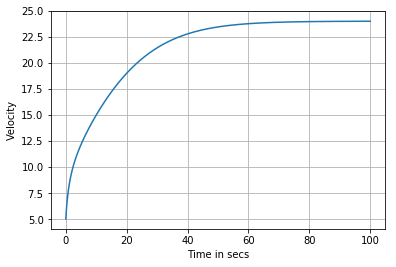

In [61]:
constant_throttle()


At time: 0.000000
	alpha 0.049958 throttle 0.200000
Vehicle velcoity 5.044926
At time: 0.010000
	alpha 0.049958 throttle 0.200600
Vehicle velcoity 5.089849
At time: 0.020000
	alpha 0.049958 throttle 0.201200
Vehicle velcoity 5.134768
At time: 0.030000
	alpha 0.049958 throttle 0.201800
Vehicle velcoity 5.179685
At time: 0.040000
	alpha 0.049958 throttle 0.202400
Vehicle velcoity 5.224598
At time: 0.050000
	alpha 0.049958 throttle 0.203000
Vehicle velcoity 5.269509
At time: 0.060000
	alpha 0.049958 throttle 0.203600
Vehicle velcoity 5.313875
At time: 0.070000
	alpha 0.049958 throttle 0.204200
Vehicle velcoity 5.357385
At time: 0.080000
	alpha 0.049958 throttle 0.204800
Vehicle velcoity 5.400067
At time: 0.090000
	alpha 0.049958 throttle 0.205400
Vehicle velcoity 5.441951
At time: 0.100000
	alpha 0.049958 throttle 0.206000
Vehicle velcoity 5.483063
At time: 0.110000
	alpha 0.049958 throttle 0.206600
Vehicle velcoity 5.523428
At time: 0.120000
	alpha 0.049958 throttle 0.207200
Vehicle velc

At time: 3.990000
	alpha 0.049958 throttle 0.439400
Vehicle velcoity 9.382685
At time: 4.000000
	alpha 0.049958 throttle 0.440000
Vehicle velcoity 9.387180
At time: 4.010000
	alpha 0.049958 throttle 0.440600
Vehicle velcoity 9.391681
At time: 4.020000
	alpha 0.049958 throttle 0.441200
Vehicle velcoity 9.396190
At time: 4.030000
	alpha 0.049958 throttle 0.441800
Vehicle velcoity 9.400705
At time: 4.040000
	alpha 0.049958 throttle 0.442400
Vehicle velcoity 9.405227
At time: 4.050000
	alpha 0.049958 throttle 0.443000
Vehicle velcoity 9.409756
At time: 4.060000
	alpha 0.049958 throttle 0.443600
Vehicle velcoity 9.414293
At time: 4.070000
	alpha 0.049958 throttle 0.444200
Vehicle velcoity 9.418836
At time: 4.080000
	alpha 0.049958 throttle 0.444800
Vehicle velcoity 9.423387
At time: 4.090000
	alpha 0.049958 throttle 0.445400
Vehicle velcoity 9.427945
At time: 4.100000
	alpha 0.049958 throttle 0.446000
Vehicle velcoity 9.432511
At time: 4.110000
	alpha 0.049958 throttle 0.446600
Vehicle velc

At time: 8.550000
	alpha 0.132552 throttle 0.500000
Vehicle velcoity 10.257881
At time: 8.560000
	alpha 0.132552 throttle 0.500000
Vehicle velcoity 10.252614
At time: 8.570000
	alpha 0.132552 throttle 0.500000
Vehicle velcoity 10.247336
At time: 8.580000
	alpha 0.132552 throttle 0.500000
Vehicle velcoity 10.242046
At time: 8.590000
	alpha 0.132552 throttle 0.500000
Vehicle velcoity 10.236744
At time: 8.600000
	alpha 0.132552 throttle 0.500000
Vehicle velcoity 10.231430
At time: 8.610000
	alpha 0.132552 throttle 0.500000
Vehicle velcoity 10.226105
At time: 8.620000
	alpha 0.132552 throttle 0.500000
Vehicle velcoity 10.220768
At time: 8.630000
	alpha 0.132552 throttle 0.500000
Vehicle velcoity 10.215420
At time: 8.640000
	alpha 0.132552 throttle 0.500000
Vehicle velcoity 10.210060
At time: 8.650000
	alpha 0.132552 throttle 0.500000
Vehicle velcoity 10.204689
At time: 8.660000
	alpha 0.132552 throttle 0.500000
Vehicle velcoity 10.199307
At time: 8.670000
	alpha 0.132552 throttle 0.500000


At time: 13.550000
	alpha 0.132552 throttle 0.500000
Vehicle velcoity 6.941558
At time: 13.560000
	alpha 0.132552 throttle 0.500000
Vehicle velcoity 6.934490
At time: 13.570000
	alpha 0.132552 throttle 0.500000
Vehicle velcoity 6.927423
At time: 13.580000
	alpha 0.132552 throttle 0.500000
Vehicle velcoity 6.920355
At time: 13.590000
	alpha 0.132552 throttle 0.500000
Vehicle velcoity 6.913288
At time: 13.600000
	alpha 0.132552 throttle 0.500000
Vehicle velcoity 6.906221
At time: 13.610000
	alpha 0.132552 throttle 0.500000
Vehicle velcoity 6.899155
At time: 13.620000
	alpha 0.132552 throttle 0.500000
Vehicle velcoity 6.892089
At time: 13.630000
	alpha 0.132552 throttle 0.500000
Vehicle velcoity 6.885023
At time: 13.640000
	alpha 0.132552 throttle 0.500000
Vehicle velcoity 6.877957
At time: 13.650000
	alpha 0.132552 throttle 0.500000
Vehicle velcoity 6.870891
At time: 13.660000
	alpha 0.132552 throttle 0.500000
Vehicle velcoity 6.863826
At time: 13.670000
	alpha 0.132552 throttle 0.500000

Vehicle velcoity 4.906977
At time: 18.550000
	alpha 0.132552 throttle 0.000000
Vehicle velcoity 4.943835
At time: 18.560000
	alpha 0.132552 throttle 0.000000
Vehicle velcoity 4.980690
At time: 18.570000
	alpha 0.132552 throttle 0.000000
Vehicle velcoity 5.017543
At time: 18.580000
	alpha 0.132552 throttle 0.000000
Vehicle velcoity 5.054393
At time: 18.590000
	alpha 0.132552 throttle 0.000000
Vehicle velcoity 5.091240
At time: 18.600000
	alpha 0.132552 throttle 0.000000
Vehicle velcoity 5.128085
At time: 18.610000
	alpha 0.132552 throttle 0.000000
Vehicle velcoity 5.164928
At time: 18.620000
	alpha 0.132552 throttle 0.000000
Vehicle velcoity 5.201768
At time: 18.630000
	alpha 0.132552 throttle 0.000000
Vehicle velcoity 5.238605
At time: 18.640000
	alpha 0.132552 throttle 0.000000
Vehicle velcoity 5.275439
At time: 18.650000
	alpha 0.132552 throttle 0.000000
Vehicle velcoity 5.312271
At time: 18.660000
	alpha 0.132552 throttle 0.000000
Vehicle velcoity 5.349101
At time: 18.670000
	alpha 

Vehicle velcoity 27.733105
At time: 23.550000
	alpha 0.000000 throttle 0.000000
Vehicle velcoity 27.777874
At time: 23.560000
	alpha 0.000000 throttle 0.000000
Vehicle velcoity 27.822625
At time: 23.570000
	alpha 0.000000 throttle 0.000000
Vehicle velcoity 27.867360
At time: 23.580000
	alpha 0.000000 throttle 0.000000
Vehicle velcoity 27.912078
At time: 23.590000
	alpha 0.000000 throttle 0.000000
Vehicle velcoity 27.956779
At time: 23.600000
	alpha 0.000000 throttle 0.000000
Vehicle velcoity 28.001463
At time: 23.610000
	alpha 0.000000 throttle 0.000000
Vehicle velcoity 28.046130
At time: 23.620000
	alpha 0.000000 throttle 0.000000
Vehicle velcoity 28.090779
At time: 23.630000
	alpha 0.000000 throttle 0.000000
Vehicle velcoity 28.135412
At time: 23.640000
	alpha 0.000000 throttle 0.000000
Vehicle velcoity 28.180028
At time: 23.650000
	alpha 0.000000 throttle 0.000000
Vehicle velcoity 28.224626
At time: 23.660000
	alpha 0.000000 throttle 0.000000
Vehicle velcoity 28.269208
At time: 23.6

	alpha 0.000000 throttle 0.000000
Vehicle velcoity 47.679409
At time: 28.550000
	alpha 0.000000 throttle 0.000000
Vehicle velcoity 47.713948
At time: 28.560000
	alpha 0.000000 throttle 0.000000
Vehicle velcoity 47.748465
At time: 28.570000
	alpha 0.000000 throttle 0.000000
Vehicle velcoity 47.782959
At time: 28.580000
	alpha 0.000000 throttle 0.000000
Vehicle velcoity 47.817431
At time: 28.590000
	alpha 0.000000 throttle 0.000000
Vehicle velcoity 47.851880
At time: 28.600000
	alpha 0.000000 throttle 0.000000
Vehicle velcoity 47.886307
At time: 28.610000
	alpha 0.000000 throttle 0.000000
Vehicle velcoity 47.920712
At time: 28.620000
	alpha 0.000000 throttle 0.000000
Vehicle velcoity 47.955094
At time: 28.630000
	alpha 0.000000 throttle 0.000000
Vehicle velcoity 47.989453
At time: 28.640000
	alpha 0.000000 throttle 0.000000
Vehicle velcoity 48.023791
At time: 28.650000
	alpha 0.000000 throttle 0.000000
Vehicle velcoity 48.058106
At time: 28.660000
	alpha 0.000000 throttle 0.000000
Vehicl

	alpha 0.000000 throttle 0.000000
Vehicle velcoity 62.192443
At time: 33.550000
	alpha 0.000000 throttle 0.000000
Vehicle velcoity 62.216138
At time: 33.560000
	alpha 0.000000 throttle 0.000000
Vehicle velcoity 62.239813
At time: 33.570000
	alpha 0.000000 throttle 0.000000
Vehicle velcoity 62.263468
At time: 33.580000
	alpha 0.000000 throttle 0.000000
Vehicle velcoity 62.287103
At time: 33.590000
	alpha 0.000000 throttle 0.000000
Vehicle velcoity 62.310718
At time: 33.600000
	alpha 0.000000 throttle 0.000000
Vehicle velcoity 62.334313
At time: 33.610000
	alpha 0.000000 throttle 0.000000
Vehicle velcoity 62.357888
At time: 33.620000
	alpha 0.000000 throttle 0.000000
Vehicle velcoity 62.381443
At time: 33.630000
	alpha 0.000000 throttle 0.000000
Vehicle velcoity 62.404978
At time: 33.640000
	alpha 0.000000 throttle 0.000000
Vehicle velcoity 62.428494
At time: 33.650000
	alpha 0.000000 throttle 0.000000
Vehicle velcoity 62.451989
At time: 33.660000
	alpha 0.000000 throttle 0.000000
Vehicl

At time: 38.540000
	alpha 0.000000 throttle 0.000000
Vehicle velcoity 71.753149
At time: 38.550000
	alpha 0.000000 throttle 0.000000
Vehicle velcoity 71.768135
At time: 38.560000
	alpha 0.000000 throttle 0.000000
Vehicle velcoity 71.783107
At time: 38.570000
	alpha 0.000000 throttle 0.000000
Vehicle velcoity 71.798064
At time: 38.580000
	alpha 0.000000 throttle 0.000000
Vehicle velcoity 71.813007
At time: 38.590000
	alpha 0.000000 throttle 0.000000
Vehicle velcoity 71.827935
At time: 38.600000
	alpha 0.000000 throttle 0.000000
Vehicle velcoity 71.842849
At time: 38.610000
	alpha 0.000000 throttle 0.000000
Vehicle velcoity 71.857748
At time: 38.620000
	alpha 0.000000 throttle 0.000000
Vehicle velcoity 71.872632
At time: 38.630000
	alpha 0.000000 throttle 0.000000
Vehicle velcoity 71.887502
At time: 38.640000
	alpha 0.000000 throttle 0.000000
Vehicle velcoity 71.902357
At time: 38.650000
	alpha 0.000000 throttle 0.000000
Vehicle velcoity 71.917198
At time: 38.660000
	alpha 0.000000 throt

At time: 43.540000
	alpha 0.000000 throttle 0.000000
Vehicle velcoity 77.645688
At time: 43.550000
	alpha 0.000000 throttle 0.000000
Vehicle velcoity 77.654688
At time: 43.560000
	alpha 0.000000 throttle 0.000000
Vehicle velcoity 77.663678
At time: 43.570000
	alpha 0.000000 throttle 0.000000
Vehicle velcoity 77.672659
At time: 43.580000
	alpha 0.000000 throttle 0.000000
Vehicle velcoity 77.681630
At time: 43.590000
	alpha 0.000000 throttle 0.000000
Vehicle velcoity 77.690592
At time: 43.600000
	alpha 0.000000 throttle 0.000000
Vehicle velcoity 77.699545
At time: 43.610000
	alpha 0.000000 throttle 0.000000
Vehicle velcoity 77.708488
At time: 43.620000
	alpha 0.000000 throttle 0.000000
Vehicle velcoity 77.717421
At time: 43.630000
	alpha 0.000000 throttle 0.000000
Vehicle velcoity 77.726345
At time: 43.640000
	alpha 0.000000 throttle 0.000000
Vehicle velcoity 77.735260
At time: 43.650000
	alpha 0.000000 throttle 0.000000
Vehicle velcoity 77.744165
At time: 43.660000
	alpha 0.000000 throt

Vehicle velcoity 81.124312
At time: 48.540000
	alpha 0.000000 throttle 0.000000
Vehicle velcoity 81.129556
At time: 48.550000
	alpha 0.000000 throttle 0.000000
Vehicle velcoity 81.134794
At time: 48.560000
	alpha 0.000000 throttle 0.000000
Vehicle velcoity 81.140027
At time: 48.570000
	alpha 0.000000 throttle 0.000000
Vehicle velcoity 81.145254
At time: 48.580000
	alpha 0.000000 throttle 0.000000
Vehicle velcoity 81.150475
At time: 48.590000
	alpha 0.000000 throttle 0.000000
Vehicle velcoity 81.155690
At time: 48.600000
	alpha 0.000000 throttle 0.000000
Vehicle velcoity 81.160899
At time: 48.610000
	alpha 0.000000 throttle 0.000000
Vehicle velcoity 81.166103
At time: 48.620000
	alpha 0.000000 throttle 0.000000
Vehicle velcoity 81.171301
At time: 48.630000
	alpha 0.000000 throttle 0.000000
Vehicle velcoity 81.176493
At time: 48.640000
	alpha 0.000000 throttle 0.000000
Vehicle velcoity 81.181680
At time: 48.650000
	alpha 0.000000 throttle 0.000000
Vehicle velcoity 81.186860
At time: 48.6

Vehicle velcoity 83.135910
At time: 53.540000
	alpha 0.000000 throttle 0.000000
Vehicle velcoity 83.138907
At time: 53.550000
	alpha 0.000000 throttle 0.000000
Vehicle velcoity 83.141900
At time: 53.560000
	alpha 0.000000 throttle 0.000000
Vehicle velcoity 83.144891
At time: 53.570000
	alpha 0.000000 throttle 0.000000
Vehicle velcoity 83.147878
At time: 53.580000
	alpha 0.000000 throttle 0.000000
Vehicle velcoity 83.150861
At time: 53.590000
	alpha 0.000000 throttle 0.000000
Vehicle velcoity 83.153841
At time: 53.600000
	alpha 0.000000 throttle 0.000000
Vehicle velcoity 83.156818
At time: 53.610000
	alpha 0.000000 throttle 0.000000
Vehicle velcoity 83.159792
At time: 53.620000
	alpha 0.000000 throttle 0.000000
Vehicle velcoity 83.162762
At time: 53.630000
	alpha 0.000000 throttle 0.000000
Vehicle velcoity 83.165729
At time: 53.640000
	alpha 0.000000 throttle 0.000000
Vehicle velcoity 83.168692
At time: 53.650000
	alpha 0.000000 throttle 0.000000
Vehicle velcoity 83.171652
At time: 53.6

	alpha 0.000000 throttle 0.000000
Vehicle velcoity 84.271080
At time: 58.490000
	alpha 0.000000 throttle 0.000000
Vehicle velcoity 84.272785
At time: 58.500000
	alpha 0.000000 throttle 0.000000
Vehicle velcoity 84.274488
At time: 58.510000
	alpha 0.000000 throttle 0.000000
Vehicle velcoity 84.276189
At time: 58.520000
	alpha 0.000000 throttle 0.000000
Vehicle velcoity 84.277888
At time: 58.530000
	alpha 0.000000 throttle 0.000000
Vehicle velcoity 84.279585
At time: 58.540000
	alpha 0.000000 throttle 0.000000
Vehicle velcoity 84.281280
At time: 58.550000
	alpha 0.000000 throttle 0.000000
Vehicle velcoity 84.282973
At time: 58.560000
	alpha 0.000000 throttle 0.000000
Vehicle velcoity 84.284664
At time: 58.570000
	alpha 0.000000 throttle 0.000000
Vehicle velcoity 84.286353
At time: 58.580000
	alpha 0.000000 throttle 0.000000
Vehicle velcoity 84.288040
At time: 58.590000
	alpha 0.000000 throttle 0.000000
Vehicle velcoity 84.289726
At time: 58.600000
	alpha 0.000000 throttle 0.000000
Vehicl

	alpha 0.000000 throttle 0.000000
Vehicle velcoity 84.924496
At time: 63.540000
	alpha 0.000000 throttle 0.000000
Vehicle velcoity 84.925449
At time: 63.550000
	alpha 0.000000 throttle 0.000000
Vehicle velcoity 84.926401
At time: 63.560000
	alpha 0.000000 throttle 0.000000
Vehicle velcoity 84.927352
At time: 63.570000
	alpha 0.000000 throttle 0.000000
Vehicle velcoity 84.928302
At time: 63.580000
	alpha 0.000000 throttle 0.000000
Vehicle velcoity 84.929250
At time: 63.590000
	alpha 0.000000 throttle 0.000000
Vehicle velcoity 84.930198
At time: 63.600000
	alpha 0.000000 throttle 0.000000
Vehicle velcoity 84.931144
At time: 63.610000
	alpha 0.000000 throttle 0.000000
Vehicle velcoity 84.932090
At time: 63.620000
	alpha 0.000000 throttle 0.000000
Vehicle velcoity 84.933034
At time: 63.630000
	alpha 0.000000 throttle 0.000000
Vehicle velcoity 84.933977
At time: 63.640000
	alpha 0.000000 throttle 0.000000
Vehicle velcoity 84.934919
At time: 63.650000
	alpha 0.000000 throttle 0.000000
Vehicl

At time: 68.530000
	alpha 0.000000 throttle 0.000000
Vehicle velcoity 85.286476
At time: 68.540000
	alpha 0.000000 throttle 0.000000
Vehicle velcoity 85.287010
At time: 68.550000
	alpha 0.000000 throttle 0.000000
Vehicle velcoity 85.287544
At time: 68.560000
	alpha 0.000000 throttle 0.000000
Vehicle velcoity 85.288077
At time: 68.570000
	alpha 0.000000 throttle 0.000000
Vehicle velcoity 85.288609
At time: 68.580000
	alpha 0.000000 throttle 0.000000
Vehicle velcoity 85.289140
At time: 68.590000
	alpha 0.000000 throttle 0.000000
Vehicle velcoity 85.289671
At time: 68.600000
	alpha 0.000000 throttle 0.000000
Vehicle velcoity 85.290201
At time: 68.610000
	alpha 0.000000 throttle 0.000000
Vehicle velcoity 85.290731
At time: 68.620000
	alpha 0.000000 throttle 0.000000
Vehicle velcoity 85.291260
At time: 68.630000
	alpha 0.000000 throttle 0.000000
Vehicle velcoity 85.291789
At time: 68.640000
	alpha 0.000000 throttle 0.000000
Vehicle velcoity 85.292317
At time: 68.650000
	alpha 0.000000 throt

Vehicle velcoity 85.507831
At time: 74.190000
	alpha 0.000000 throttle 0.000000
Vehicle velcoity 85.508108
At time: 74.200000
	alpha 0.000000 throttle 0.000000
Vehicle velcoity 85.508385
At time: 74.210000
	alpha 0.000000 throttle 0.000000
Vehicle velcoity 85.508661
At time: 74.220000
	alpha 0.000000 throttle 0.000000
Vehicle velcoity 85.508937
At time: 74.230000
	alpha 0.000000 throttle 0.000000
Vehicle velcoity 85.509212
At time: 74.240000
	alpha 0.000000 throttle 0.000000
Vehicle velcoity 85.509488
At time: 74.250000
	alpha 0.000000 throttle 0.000000
Vehicle velcoity 85.509763
At time: 74.260000
	alpha 0.000000 throttle 0.000000
Vehicle velcoity 85.510037
At time: 74.270000
	alpha 0.000000 throttle 0.000000
Vehicle velcoity 85.510312
At time: 74.280000
	alpha 0.000000 throttle 0.000000
Vehicle velcoity 85.510586
At time: 74.290000
	alpha 0.000000 throttle 0.000000
Vehicle velcoity 85.510859
At time: 74.300000
	alpha 0.000000 throttle 0.000000
Vehicle velcoity 85.511133
At time: 74.3

Vehicle velcoity 85.602236
At time: 78.530000
	alpha 0.000000 throttle 0.000000
Vehicle velcoity 85.602403
At time: 78.540000
	alpha 0.000000 throttle 0.000000
Vehicle velcoity 85.602570
At time: 78.550000
	alpha 0.000000 throttle 0.000000
Vehicle velcoity 85.602737
At time: 78.560000
	alpha 0.000000 throttle 0.000000
Vehicle velcoity 85.602903
At time: 78.570000
	alpha 0.000000 throttle 0.000000
Vehicle velcoity 85.603070
At time: 78.580000
	alpha 0.000000 throttle 0.000000
Vehicle velcoity 85.603236
At time: 78.590000
	alpha 0.000000 throttle 0.000000
Vehicle velcoity 85.603402
At time: 78.600000
	alpha 0.000000 throttle 0.000000
Vehicle velcoity 85.603567
At time: 78.610000
	alpha 0.000000 throttle 0.000000
Vehicle velcoity 85.603733
At time: 78.620000
	alpha 0.000000 throttle 0.000000
Vehicle velcoity 85.603898
At time: 78.630000
	alpha 0.000000 throttle 0.000000
Vehicle velcoity 85.604063
At time: 78.640000
	alpha 0.000000 throttle 0.000000
Vehicle velcoity 85.604228
At time: 78.6

Vehicle velcoity 85.665584
At time: 83.530000
	alpha 0.000000 throttle 0.000000
Vehicle velcoity 85.665677
At time: 83.540000
	alpha 0.000000 throttle 0.000000
Vehicle velcoity 85.665770
At time: 83.550000
	alpha 0.000000 throttle 0.000000
Vehicle velcoity 85.665863
At time: 83.560000
	alpha 0.000000 throttle 0.000000
Vehicle velcoity 85.665956
At time: 83.570000
	alpha 0.000000 throttle 0.000000
Vehicle velcoity 85.666049
At time: 83.580000
	alpha 0.000000 throttle 0.000000
Vehicle velcoity 85.666142
At time: 83.590000
	alpha 0.000000 throttle 0.000000
Vehicle velcoity 85.666235
At time: 83.600000
	alpha 0.000000 throttle 0.000000
Vehicle velcoity 85.666327
At time: 83.610000
	alpha 0.000000 throttle 0.000000
Vehicle velcoity 85.666419
At time: 83.620000
	alpha 0.000000 throttle 0.000000
Vehicle velcoity 85.666512
At time: 83.630000
	alpha 0.000000 throttle 0.000000
Vehicle velcoity 85.666604
At time: 83.640000
	alpha 0.000000 throttle 0.000000
Vehicle velcoity 85.666696
At time: 83.6

	alpha 0.000000 throttle 0.000000
Vehicle velcoity 85.700951
At time: 88.530000
	alpha 0.000000 throttle 0.000000
Vehicle velcoity 85.701003
At time: 88.540000
	alpha 0.000000 throttle 0.000000
Vehicle velcoity 85.701055
At time: 88.550000
	alpha 0.000000 throttle 0.000000
Vehicle velcoity 85.701107
At time: 88.560000
	alpha 0.000000 throttle 0.000000
Vehicle velcoity 85.701159
At time: 88.570000
	alpha 0.000000 throttle 0.000000
Vehicle velcoity 85.701210
At time: 88.580000
	alpha 0.000000 throttle 0.000000
Vehicle velcoity 85.701262
At time: 88.590000
	alpha 0.000000 throttle 0.000000
Vehicle velcoity 85.701314
At time: 88.600000
	alpha 0.000000 throttle 0.000000
Vehicle velcoity 85.701366
At time: 88.610000
	alpha 0.000000 throttle 0.000000
Vehicle velcoity 85.701417
At time: 88.620000
	alpha 0.000000 throttle 0.000000
Vehicle velcoity 85.701469
At time: 88.630000
	alpha 0.000000 throttle 0.000000
Vehicle velcoity 85.701520
At time: 88.640000
	alpha 0.000000 throttle 0.000000
Vehicl

	alpha 0.000000 throttle 0.000000
Vehicle velcoity 85.720691
At time: 93.530000
	alpha 0.000000 throttle 0.000000
Vehicle velcoity 85.720720
At time: 93.540000
	alpha 0.000000 throttle 0.000000
Vehicle velcoity 85.720749
At time: 93.550000
	alpha 0.000000 throttle 0.000000
Vehicle velcoity 85.720778
At time: 93.560000
	alpha 0.000000 throttle 0.000000
Vehicle velcoity 85.720807
At time: 93.570000
	alpha 0.000000 throttle 0.000000
Vehicle velcoity 85.720836
At time: 93.580000
	alpha 0.000000 throttle 0.000000
Vehicle velcoity 85.720865
At time: 93.590000
	alpha 0.000000 throttle 0.000000
Vehicle velcoity 85.720894
At time: 93.600000
	alpha 0.000000 throttle 0.000000
Vehicle velcoity 85.720922
At time: 93.610000
	alpha 0.000000 throttle 0.000000
Vehicle velcoity 85.720951
At time: 93.620000
	alpha 0.000000 throttle 0.000000
Vehicle velcoity 85.720980
At time: 93.630000
	alpha 0.000000 throttle 0.000000
Vehicle velcoity 85.721009
At time: 93.640000
	alpha 0.000000 throttle 0.000000
Vehicl

At time: 98.520000
	alpha 0.000000 throttle 0.000000
Vehicle velcoity 85.731708
At time: 98.530000
	alpha 0.000000 throttle 0.000000
Vehicle velcoity 85.731724
At time: 98.540000
	alpha 0.000000 throttle 0.000000
Vehicle velcoity 85.731740
At time: 98.550000
	alpha 0.000000 throttle 0.000000
Vehicle velcoity 85.731756
At time: 98.560000
	alpha 0.000000 throttle 0.000000
Vehicle velcoity 85.731772
At time: 98.570000
	alpha 0.000000 throttle 0.000000
Vehicle velcoity 85.731788
At time: 98.580000
	alpha 0.000000 throttle 0.000000
Vehicle velcoity 85.731805
At time: 98.590000
	alpha 0.000000 throttle 0.000000
Vehicle velcoity 85.731821
At time: 98.600000
	alpha 0.000000 throttle 0.000000
Vehicle velcoity 85.731837
At time: 98.610000
	alpha 0.000000 throttle 0.000000
Vehicle velcoity 85.731853
At time: 98.620000
	alpha 0.000000 throttle 0.000000
Vehicle velcoity 85.731869
At time: 98.630000
	alpha 0.000000 throttle 0.000000
Vehicle velcoity 85.731885
At time: 98.640000
	alpha 0.000000 throt

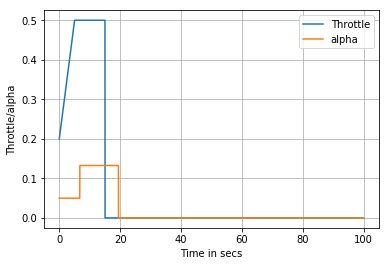

In [62]:
variable_throttle()

If you have implemented the vehicle model and inputs correctly, you should see that the vehicle crosses the ramp at ~15s where the throttle input begins to decrease.